In [1]:
from pymongo import MongoClient
import pandas as pd
import geopandas as gpd
from datetime import datetime
from sklearn.cluster import OPTICS
import json
import numpy as np
from shapely import GeometryCollection

In [5]:
def export_accidents_for_training(region_name: str, next_month : int = None, year: int = None):
    client = MongoClient("mongodb://localhost:27017/accidents")
    collection = client['accidents']['accidents']
    if next_month is None and year is None:
        next_month = datetime.now().month + 1
        year = datetime.now().year
    year_datetime = year
    required_months = [
        next_month - 1 if next_month != 1 else 12,
        next_month,
        next_month + 1 if next_month != 12 else 1,
    ]
    agg_pipeline = [
        {
            "$addFields": {"month": {"$month": '$datetime'}, "year": {"$year": '$datetime'}}
        },
        {
            "$match": {
                "region_name": region_name,
                "year" : {"$gte": year_datetime - 6, "$lt": year},
                "month": {"$in": required_months},
                "type": {"$in": [
                    "Столкновение",
                    "Наезд на пешехода",
                    "Съезд с дороги",
                    "Опрокидывание",
                    "Наезд на велосипедиста"
                ]}
            }
        },     
    ]
    accidents_df = pd.DataFrame(list(collection.aggregate(agg_pipeline)))
    accidents_df = accidents_df.loc[(accidents_df.latitude != '') & (accidents_df.longitude != '')]
    accidents_df = accidents_df.loc[(accidents_df.latitude != '.') & (accidents_df.longitude != '.')]
    accidents_df['longitude'] = pd.to_numeric(accidents_df['longitude'], errors='coerce')
    accidents_df['latitude'] = pd.to_numeric(accidents_df['latitude'], errors='coerce')
    accidents_df = accidents_df.dropna(subset=['longitude', 'latitude'])
    accidents_df = accidents_df.loc[(accidents_df.latitude != 0) & (accidents_df.longitude != 0)]
    accidents_gdf = gpd.GeoDataFrame(accidents_df, geometry=gpd.points_from_xy(x=accidents_df.longitude, y=accidents_df.latitude), crs="EPSG:4326")
    return accidents_gdf

def export_accidents_for_validate(region_name: str, month: int, year: int):
    client = MongoClient("mongodb://localhost:27017/accidents")
    collection = client['accidents']['accidents']
    agg_pipeline = [
        {
            "$addFields": {"month": {"$month": '$datetime'}, "year": {"$year": '$datetime'}}
        },
        {
            "$match": {
                "region_name": region_name,
                "year" : year,
                "month": month ,
                "type": {"$in": [
                    "Столкновение",
                    "Наезд на пешехода",
                    "Съезд с дороги",
                    "Опрокидывание",
                    "Наезд на велосипедиста"
                ]}
            }
        },  
    ]
    accidents_df = pd.DataFrame(list(collection.aggregate(agg_pipeline)))
    accidents_df = accidents_df.loc[(accidents_df.latitude != '') & (accidents_df.longitude != '')]
    accidents_df = accidents_df.loc[(accidents_df.latitude != '.') & (accidents_df.longitude != '.')]
    accidents_df['longitude'] = pd.to_numeric(accidents_df['longitude'], errors='coerce')
    accidents_df['latitude'] = pd.to_numeric(accidents_df['latitude'], errors='coerce')
    accidents_df = accidents_df.dropna(subset=['longitude', 'latitude'])
    accidents_df = accidents_df.loc[(accidents_df.latitude != 0) & (accidents_df.longitude != 0)]
    accidents_gdf = gpd.GeoDataFrame(accidents_df, geometry=gpd.points_from_xy(x=accidents_df.longitude, y=accidents_df.latitude), crs="EPSG:4326")
    return accidents_gdf

def predict_clusters(accidents_gdf: pd.DataFrame, min_samples: int = 5, metric: str = 'minkowski'):
    optics_clusterer = OPTICS(min_samples=min_samples, max_eps=300, metric=metric)

    accidents_gdf['utm_geometry'] = accidents_gdf['geometry'].to_crs(accidents_gdf.estimate_utm_crs())
    accidents_gdf['utm_longitude'] = accidents_gdf['utm_geometry'].x.replace(np.inf, None)
    accidents_gdf['utm_latitude'] = accidents_gdf['utm_geometry'].y.replace(np.inf, None)
    accidents_gdf = accidents_gdf.dropna(subset=['utm_latitude', 'utm_longitude'])
    accidents_gdf['cluster'] = optics_clusterer.fit_predict(accidents_gdf[['utm_longitude', 'utm_latitude']])
    accidents_gdf = accidents_gdf.loc[accidents_gdf.cluster != -1]
    clusters = gpd.GeoDataFrame(accidents_gdf.groupby('cluster').apply(lambda x: x.dissolve().convex_hull, include_groups=False), geometry=0, crs="EPSG:4326")
    polygons = GeometryCollection(list(clusters.geometry))
    return polygons

def construct_clusters_for_test(accidents_gdf: pd.DataFrame, min_samples: int = 3, metric: str = 'minkowski'):
    optics_clusterer = OPTICS(min_samples=min_samples, max_eps=700, metric=metric)

    accidents_gdf['utm_geometry'] = accidents_gdf['geometry'].to_crs(accidents_gdf.estimate_utm_crs())
    accidents_gdf['utm_longitude'] = accidents_gdf['utm_geometry'].x.replace(np.inf, None)
    accidents_gdf['utm_latitude'] = accidents_gdf['utm_geometry'].y.replace(np.inf, None)
    accidents_gdf = accidents_gdf.dropna(subset=['utm_latitude', 'utm_longitude'])
    accidents_gdf['cluster'] = optics_clusterer.fit_predict(accidents_gdf[['utm_longitude', 'utm_latitude']])
    accidents_gdf_without_extra_cluster = accidents_gdf.loc[accidents_gdf.cluster != -1]
    clusters = gpd.GeoDataFrame(accidents_gdf_without_extra_cluster.groupby('cluster').apply(lambda x: x.dissolve().convex_hull, include_groups=False).reset_index(), geometry=0)
    polygons = GeometryCollection(list(clusters.geometry))

    return accidents_gdf_without_extra_cluster, polygons

In [10]:
def get_metrics():
    metrics = []
    for region in ["г. Санкт-Петербург", "Краснодарский край", "Республика Коми"]:
        for month in range(1, 13):
            for metric in ['minkowski', 'cosine', 'euclidean', 'manhattan', 'canberra', 'chebyshev']:
                try:
                    print(f"Computing metrics for {region}, {month}, {metric}")
                    train_accidents = export_accidents_for_training(region, month, 2023)
                    test_accidents = export_accidents_for_validate(region, month, 2023)
                    predicted_clusters = predict_clusters(train_accidents, metric=metric)
                    test_accidents_gdf_without_extra_cluster, polygons = construct_clusters_for_test(test_accidents, min_samples=3, metric=metric)
                    metrics_dict = {
                        "region": region,
                        "month": month,
                        "metric": metric,
                        "raw_precision": test_accidents.within(predicted_clusters).value_counts()[True] / len(test_accidents),
                        "precision": test_accidents_gdf_without_extra_cluster.within(predicted_clusters).value_counts()[True] / len(test_accidents_gdf_without_extra_cluster),
                        "IOU": polygons.intersection(predicted_clusters).area / polygons.union(predicted_clusters).area
                    }
                    metrics.append(metrics_dict)
                    print(metrics_dict)
                except Exception as e:
                    print(e)
                    continue
    return pd.DataFrame(metrics)

In [ ]:
metrics = get_metrics()

In [13]:
metrics.to_csv("metrics.csv")

<Axes: xlabel='metric'>

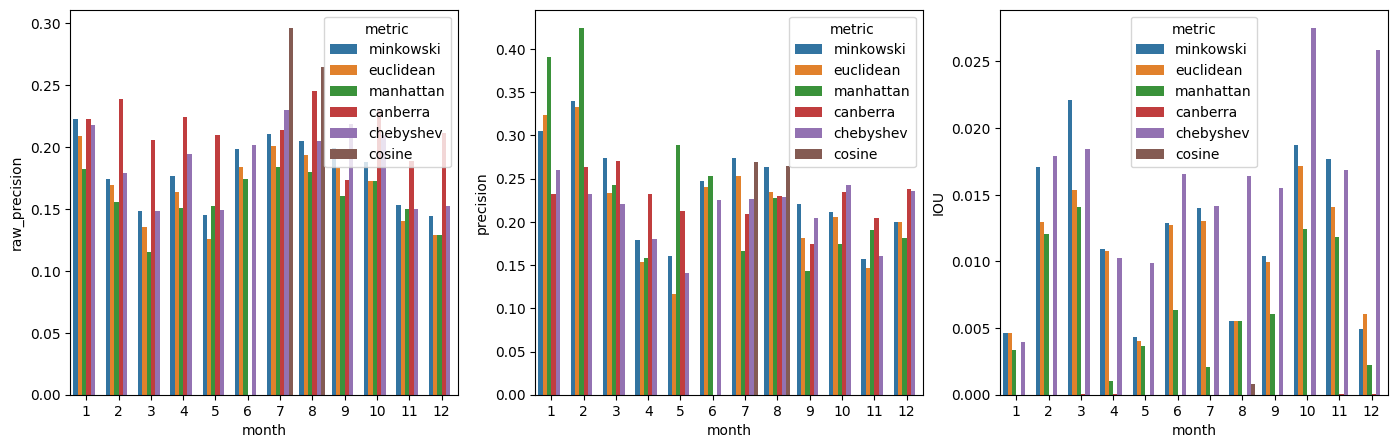

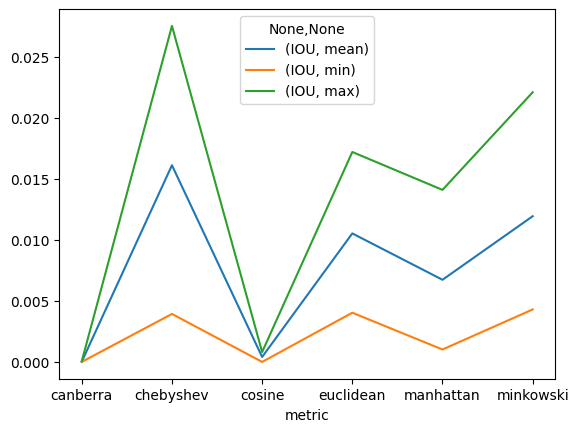

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
# plt.figure()
fix, (ax_raw_precision, ax_precision, ax_iou) = plt.subplots(1, 3, figsize=(17, 5))
sns.barplot(metrics.loc[metrics.region == 'г. Санкт-Петербург'], x='month', y='raw_precision', hue="metric", ax=ax_raw_precision)
sns.barplot(metrics.loc[metrics.region == 'г. Санкт-Петербург'], x='month', y='precision', hue="metric", ax=ax_precision)
sns.barplot(metrics.loc[metrics.region == 'г. Санкт-Петербург'], x='month', y='IOU', hue="metric", ax=ax_iou)
display(metrics.loc[metrics.region == 'г. Санкт-Петербург'][['metric', 'IOU']].groupby('metric').aggregate(['mean', 'min', 'max']).plot())
plt.show()

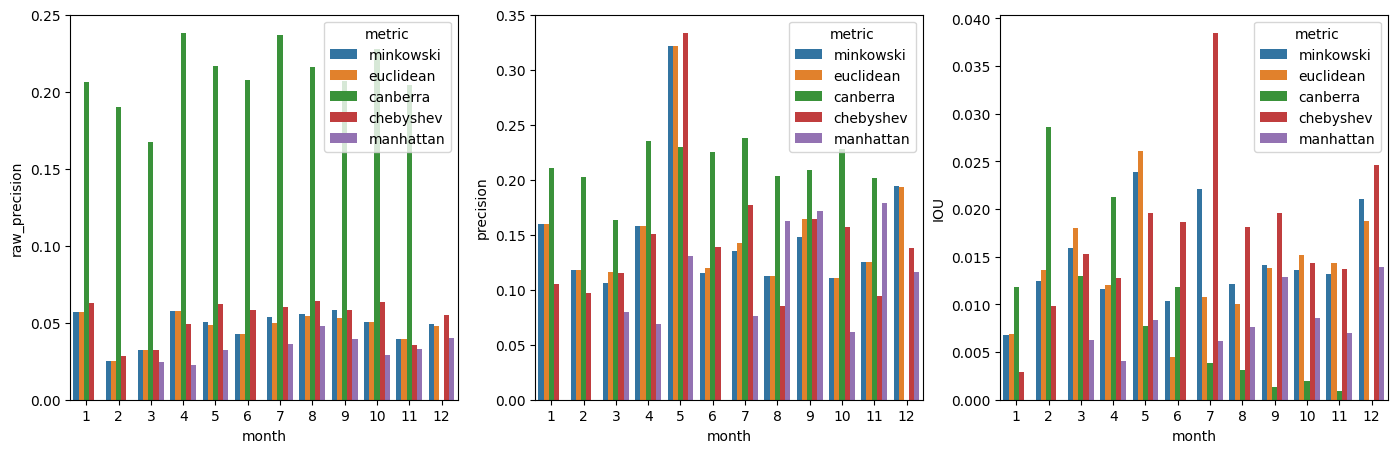

In [27]:
fix, (ax_raw_precision, ax_precision, ax_iou) = plt.subplots(1, 3, figsize=(17, 5))
sns.barplot(metrics.loc[metrics.region == 'Краснодарский край'], x='month', y='raw_precision', hue="metric", ax=ax_raw_precision)
sns.barplot(metrics.loc[metrics.region == 'Краснодарский край'], x='month', y='precision', hue="metric", ax=ax_precision)
sns.barplot(metrics.loc[metrics.region == 'Краснодарский край'], x='month', y='IOU', hue="metric", ax=ax_iou)
plt.show()

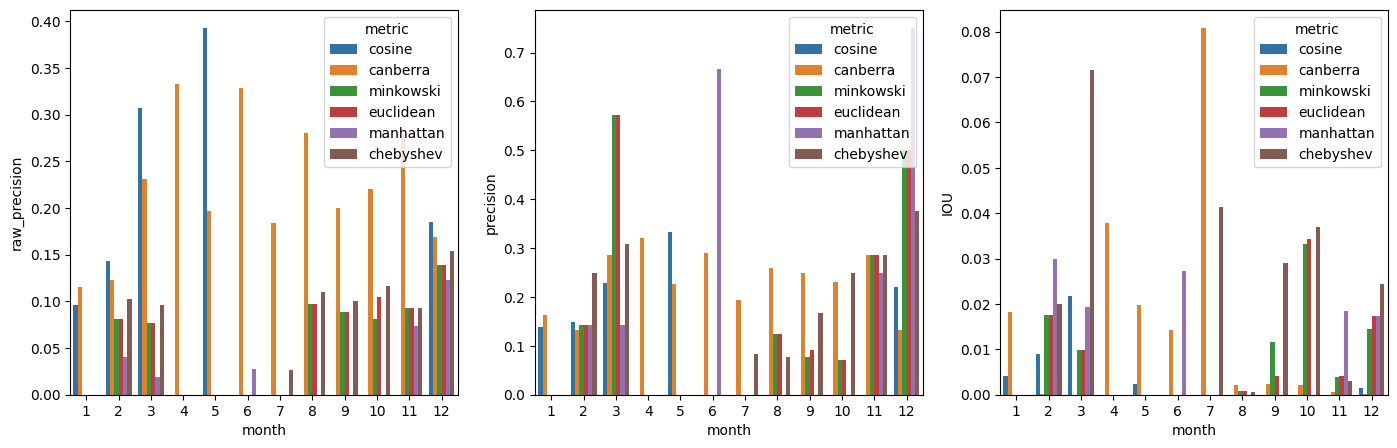

In [28]:
fix, (ax_raw_precision, ax_precision, ax_iou) = plt.subplots(1, 3, figsize=(17, 5))
sns.barplot(metrics.loc[metrics.region == 'Республика Коми'], x='month', y='raw_precision', hue="metric", ax=ax_raw_precision)
sns.barplot(metrics.loc[metrics.region == 'Республика Коми'], x='month', y='precision', hue="metric", ax=ax_precision)
sns.barplot(metrics.loc[metrics.region == 'Республика Коми'], x='month', y='IOU', hue="metric", ax=ax_iou)
plt.show()

In [48]:
train_accidents = export_accidents_for_training('г. Санкт-Петербург', 7, 2023)
test_accidents = export_accidents_for_validate('г. Санкт-Петербург', 7, 2023)
predicted_clusters = predict_clusters(train_accidents, min_samples=10, metric='chebyshev')
test_accidents_gdf_without_extra_cluster, polygons = construct_clusters_for_test(test_accidents, min_samples=3, metric="chebyshev")

d:\Sreda_DA\sreda_venv\lib\site-packages\sklearn\cluster\_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [47]:
import shapely
gpd.GeoDataFrame(predicted_clusters.geoms).to_csv('clusters.csv')